# Trade-off entre sesgo y varianza, Ensambles, etc.

A lo largo del notebook vamos a trabajar con el siguiente dataset:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## Trade-off entre sesgo y varianza


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import svm

import sklearn.metrics as metrics

1. Abrir el dataset

In [3]:
data = pd.read_csv("Datasets/weatherAUS.csv")
data.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  \
0       1007.1       8.0       NaN     16.9     21.8         No      0.0   
1       1007.8       NaN       NaN     17.2     24.3         No      0.0   
2       1008.7       NaN       2.0     21.0     23.2         No      0.0   
3       1012.8       NaN       NaN     18.1     26.5         No      1.0   
4       1006.0       7.0       8.0     17.8     29.7         No      0.2   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 24 columns]

Contamos cuántos valores no-nulos hay

In [4]:
data.count().sort_values()

Sunshine          74377
Evaporation       81350
Cloud3pm          85099
Cloud9am          88536
Pressure9am      128179
Pressure3pm      128212
WindDir9am       132180
WindGustDir      132863
WindGustSpeed    132923
WindDir3pm       138415
Humidity3pm      138583
Temp3pm          139467
WindSpeed3pm     139563
Humidity9am      140419
RainToday        140787
Rainfall         140787
WindSpeed9am     140845
Temp9am          141289
MinTemp          141556
MaxTemp          141871
Date             142193
Location         142193
RISK_MM          142193
RainTomorrow     142193
dtype: int64

2. Tirar las columnas que no nos interesan, entre ellas las que tienen pocos datos (menos de cien mil). Además, tirar 'Location' y 'Date', ya que no nos interesa el lugar ni fecha (al menos en este análisis), y 'RISK_MM', porque es un *leak*. Para googlear: ¿qué es un leak?

In [5]:
columnas_descartables = data[['Date','Location','RISK_MM']]
data = data.drop(columns=columnas_descartables)
data.shape

(142193, 21)

3. Tirar todas las filas que tengan valores nulos.

In [6]:
data = data.dropna()
print(data.shape)
data.head()

(56420, 21)


MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
5939     17.9     35.2       0.0         12.0      12.3         SSW   
5940     18.4     28.9       0.0         14.8      13.0           S   
5942     19.4     37.6       0.0         10.8      10.6         NNE   
5943     21.9     38.4       0.0         11.4      12.2         WNW   
5944     24.2     41.0       0.0         11.2       8.4         WNW   

      WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity9am  \
5939           48.0        ENE         SW           6.0  ...         20.0   
5940           37.0        SSE        SSE          19.0  ...         30.0   
5942           46.0        NNE        NNW          30.0  ...         42.0   
5943           31.0        WNW        WSW           6.0  ...         37.0   
5944           35.0         NW        WNW          17.0  ...         19.0   

      Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
5939         13.0       1006.3       1004.4       2.0       5.0     26.6   
5940          8.0       1012.9       1012.1       1.0       1.0     20.3   
5942         22.0       1012.3       1009.2       1.0       6.0     28.7   
5943         22.0       1012.7       1009.1       1.0       5.0     29.1   
5944         15.0       1010.7       1007.4       1.0       6.0     33.6   

      Temp3pm  RainToday RainTomorrow  
5939     33.4         No           No  
5940     27.0         No           No  
5942     34.9         No           No  
5943     35.6         No           No  
5944     37.6         No           No  

[5 rows x 21 columns]

4. Para simplificar el preprocesamiento, también tirar todas las columnas que tengan valores categóricos. ¿Por qué no nos molesta tirar 'RainToday'?

In [7]:
columnas_descartables = data[['WindGustDir','WindDir9am','WindDir3pm']]
data = data.drop(columns=columnas_descartables)
data.sample()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
84742     22.1     32.1       0.4          8.2       9.2           22.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
84742           4.0          11.0         62.0         56.0       1015.5   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
84742       1011.8       4.0       5.0     28.2     29.6        No   

      RainTomorrow  
84742           No

5. Realizar un countplot para ver cuántos casos hay de lluvia y no-lluvia.

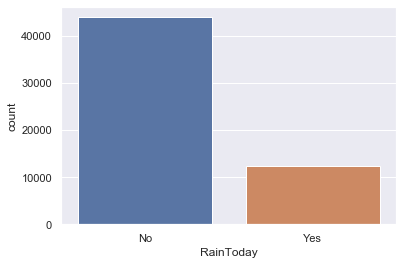

In [8]:
sns.countplot(data.RainToday)
plt.show()

Y hacer el `pairplot` para ver cómo se relacionan las variables. Recuerden que este gráfico puede llevar bastante tiempo.

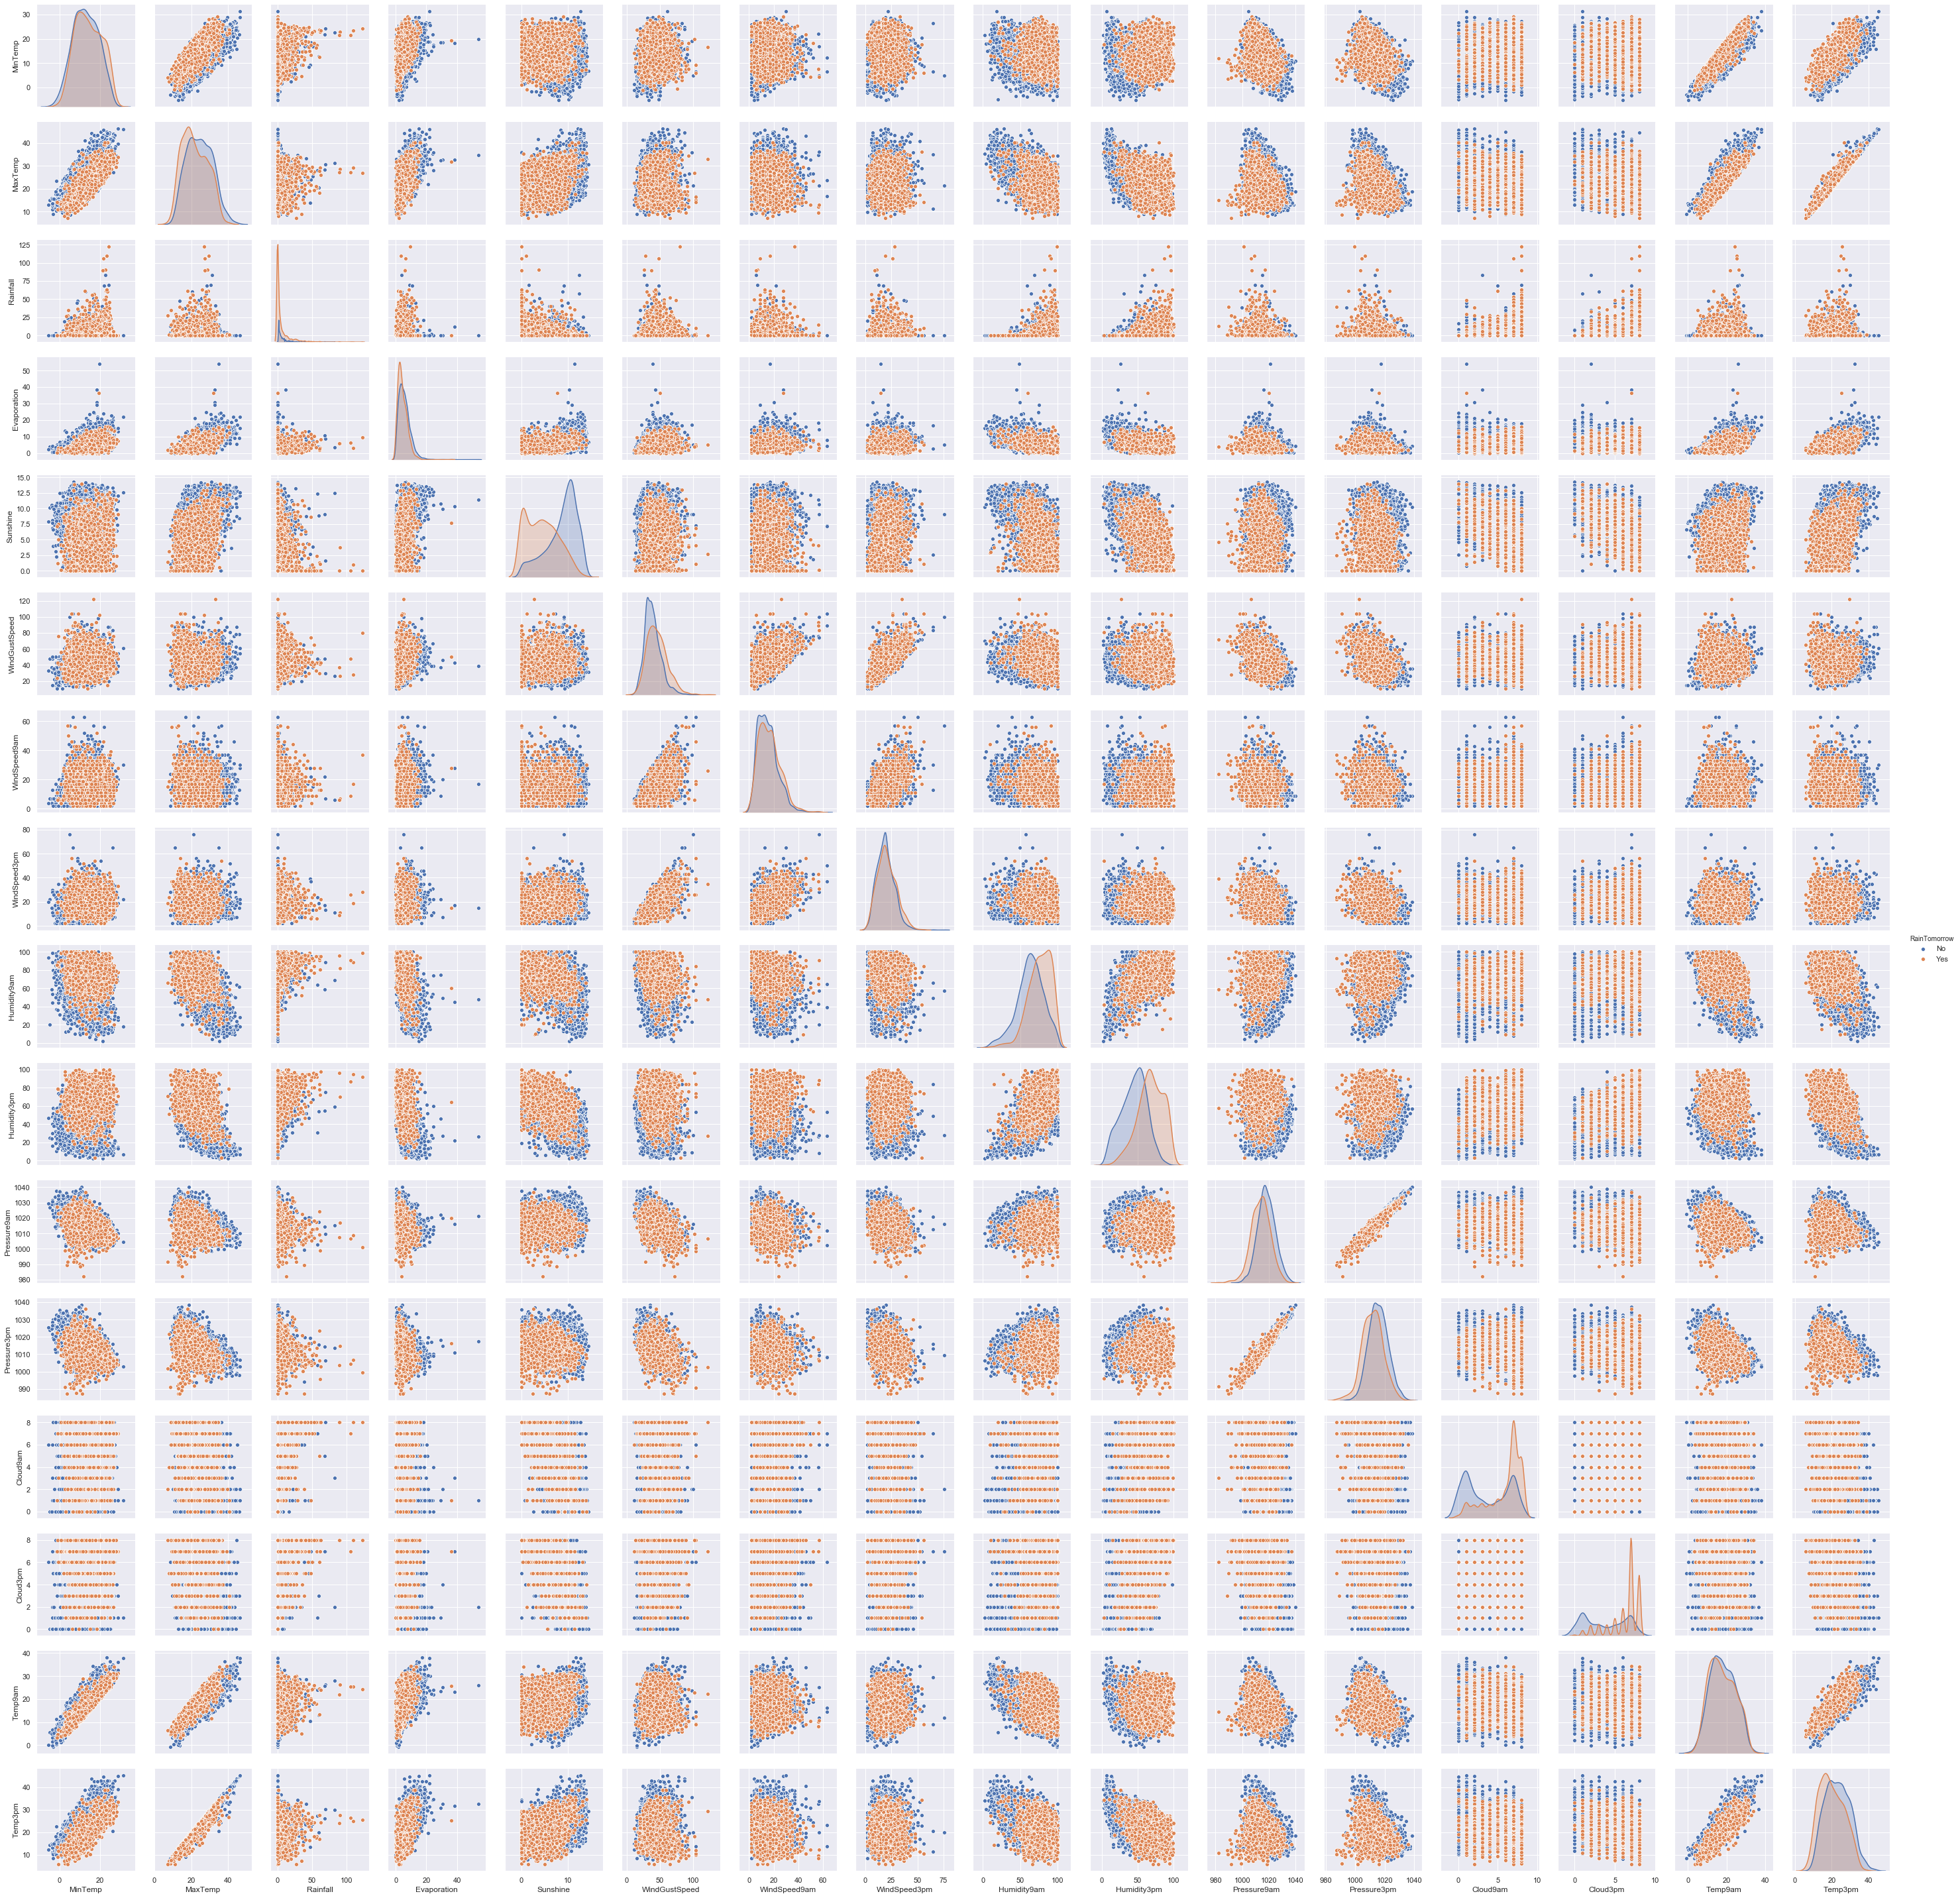

In [9]:
sns.pairplot(data.sample(frac = 0.1), hue = 'RainTomorrow')

Hay algunas que parecen *correlacionadas* (¿Qué significa eso?). Tratamos de cuantificarlo.

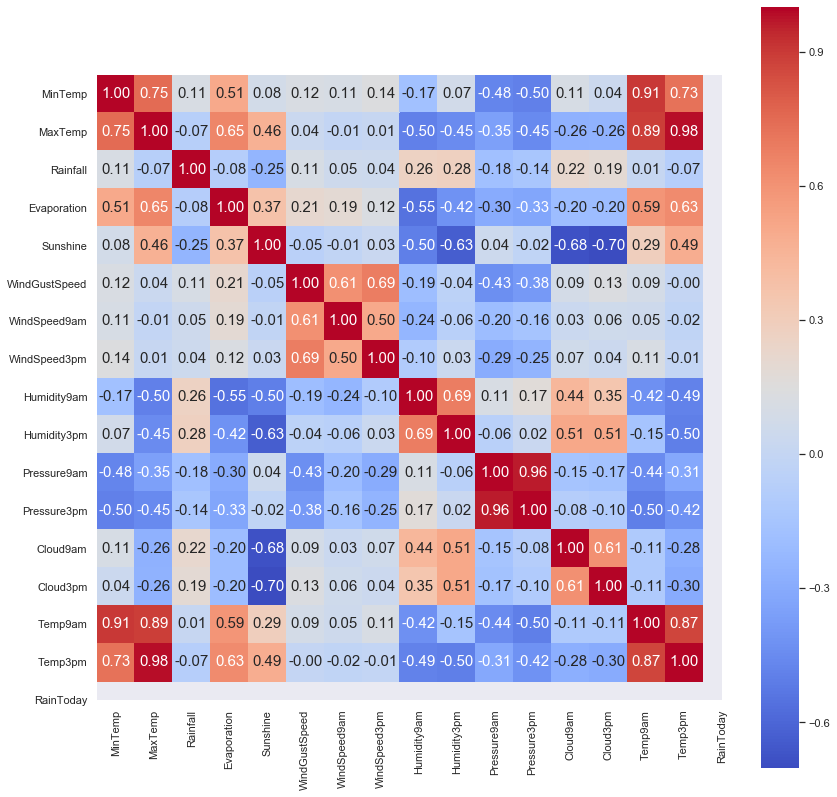

In [10]:
corr = data.drop(columns = ['RainTomorrow']).corr(method='pearson') # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data.drop(columns = ['RainTomorrow']).columns, 
           yticklabels= data.drop(columns = ['RainTomorrow']).columns,
           cmap= 'coolwarm')

plt.show()

En base a la correlación, podemos descartar (o no) algunas variables. **Para pensar**, ¿por qué haríamos (o no) esto?

In [11]:
# data = data.drop(columns=['Temp3pm', 'Pressure9am', 'NuevaVariable'])
data = data.drop(columns=['Temp3pm', 'Pressure9am'])

6. Llevar 'RainTomorrow' a una variable númerica

In [12]:
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})
data.sample(10)


MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
77880      13.0     25.7       0.0          6.0      12.5           43.0   
136802     25.6     30.8       0.0          4.2       2.4           52.0   
35153       6.9     15.4       0.0          3.8       8.5           44.0   
84184      10.7     21.7       0.0          3.8       4.3           22.0   
92740      17.2     27.2       0.0          4.6       3.2           31.0   
116056      9.4     28.9       0.0          4.6      12.1           41.0   
100824      3.5     14.8       0.2          1.0       7.9           24.0   
68985      12.6     24.9       0.0          6.2       8.5           28.0   
23094      20.0     22.0       0.4          5.0       0.0           41.0   
69352       8.9     28.3       0.0          5.2      10.7           22.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure3pm  \
77880           13.0          22.0         58.0         37.0       1016.6   
136802          11.0          19.0         78.0         98.0       1005.9   
35153           26.0          20.0         42.0         51.0       1016.7   
84184            9.0           7.0         66.0         62.0       1022.4   
92740           11.0          13.0         76.0         95.0       1014.9   
116056          26.0           9.0         53.0         23.0       1015.0   
100824          11.0           2.0         87.0         57.0       1025.9   
68985           13.0          15.0         76.0         35.0       1019.6   
23094           22.0          22.0         92.0         98.0       1012.9   
69352           13.0           9.0         68.0         22.0       1020.1   

        Cloud9am  Cloud3pm  Temp9am RainToday  RainTomorrow  
77880        2.0       6.0     17.5        No             0  
136802       7.0       7.0     30.4        No             1  
35153        3.0       7.0     11.3        No             0  
84184        5.0       7.0     16.4        No             0  
92740        7.0       8.0     22.8        No             1  
116056       3.0       1.0     20.2        No             0  
100824       5.0       6.0      9.2        No             0  
68985        7.0       7.0     14.4        No             0  
23094        7.0       8.0     20.6        No             1  
69352        0.0       1.0     16.3        No             0

### Datos de entrenamiento y casos *benchmark*

Generamos casos base contra los cuales comparar nuestros resultados.

1. Elegir variables de entrenamiento (empezar con dos) y separar las etiquetas

In [17]:
columnas_entrenamiento = ['WindGustSpeed','Evaporation']
X = data[columnas_entrenamiento]
y = data.RainToday

2. Generar un modelo que diga siempre que NO va a llover y medir su exactitud.

In [22]:
#Todos Ceros
y_pred = np.array(y.shape)
accuracy_ceros = metrics.accuracy_score(y,y_pred)
print(accuracy_ceros)

ValueError: Found input variables with inconsistent numbers of samples: [56420, 1]

Y generar otro modelo que diga siempre que va a llover y medir su exactitud.

In [ ]:
#Todos Unos
y_pred = COMPLETAR
accuracy_unos = COMPLETAR
print(accuracy_unos)

3. Generar un modelo que elija al azar si llueve o no

In [ ]:
#Todos al azar
n = 20 #Lo hacemos varias veces para tener una idea de la desviacion
accuracy_random = []
for i in range(n):
    y_pred = np.random.randint(2, size=y.size)
    metrics.accuracy_score(y,y_pred)
    accuracy_random.append(metrics.accuracy_score(y,y_pred))

accuracy_random = np.array(accuracy_random)
print(accuracy_random.mean(), '+-', accuracy_random.std())

## Sesgo y varianza

1. Separar los datos en train/test. ¿Para qué sirve `stratify`?

In [ ]:
X_train, X_test, y_train, y_test = COMPLETAR(COMPLETAR, stratify = y)

#### Curva de validación/complejidad

2. Vamos a entrenar distintos modelos de árboles para clasificación, desde poco profundos (profundidad 1) a muy profundos (profundidad 30). Definir las profundidades sobre las cuales iteraremos.

In [ ]:
profundidades = COMPLETAR

3. Definidir cuatro listas en las que guardaremos los valores medios y desviaciones estándar de los scores que saldran de una validación cruzada.

In [ ]:
cv_scores_train_mean = []
cv_scores_train_std = []
COMPLETAR = [] # para test
COMPLETAR = [] # para test

4. Iterar sobre las profundidades. En cada iteración, crear un `DecisionTreeClassifier` para esa profundidad y evaluarlo usando `cross_validate`. Una vez evaluado, agregar a las listas creadas anteriormente las métricas pertinentes.

In [ ]:
for max_depth in profundidades:
    clc = DecisionTreeClassifier(COMPLETAR, random_state = 42)
    scores = cross_validate(COMPLETAR, COMPLETAR, COMPLETAR, 
                            cv = 10, scoring = 'accuracy', n_jobs = -1, return_train_score=True)
    
    cv_scores_train_mean.append(scores['train_score'].mean())
    cv_scores_train_std.append(scores['train_score'].std())
    
    cv_scores_test_mean.append(COMPLETAR)
    cv_scores_test_std.append(COMPLETAR)
    
### Convertimos las listas en arreglos de numpy para facilitar el trabajo.
cv_scores_train_mean = np.array(cv_scores_train_mean)
cv_scores_train_std = np.array(cv_scores_train_std)
cv_scores_test_mean = np.array(cv_scores_test_mean)
cv_scores_test_std = np.array(cv_scores_test_std)

5. Plotear, con sus barrar de error, los desempeños en el conjunto de train y en el conjunto de test en función de la profundidad del árbol.

In [ ]:
plt.figure(figsize = (8,6))
plt.errorbar(COMPLETAR, COMPLETAR, yerr = cv_scores_train_std , label = 'Train')
plt.errorbar(COMPLETAR, COMPLETAR, yerr = cv_scores_test_std, label = 'Test')
plt.xlabel('Profundidad del arbol (complejidad)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6. Vemos cómo quedan las fronteras para un clasificador sesgado, uno intermedio y uno con alta varianza.

In [ ]:
clf_1 = DecisionTreeClassifier(max_depth = 1, random_state=42)
clf_6 = DecisionTreeClassifier(max_depth = 6, random_state=42)
clf_25 = DecisionTreeClassifier(max_depth = 25, random_state=42)

clf_1.fit(X_train,y_train)
clf_6.fit(X_train,y_train)
clf_25.fit(X_train,y_train)

In [ ]:
N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (18,5))

#Grafico Clasificador Sesgado
plt.subplot(1,3,1)
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf_1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

# Grafico
plt.subplot(1,3,2)
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
Z = clf_6.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

#Grafico Clasificador alta varianza
plt.subplot(1,3,3)
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
Z = clf_25.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

7. Por último, calcular los errores de cada modelo sobre el conjunto de held-out. 

In [ ]:
y_test_pred = clf_1.COMPLETAR(COMPLETAR)
print(metrics.accuracy_score(y_test,y_test_pred))

y_test_pred = COMPLETAR
print(COMPLETAR)

y_test_pred = COMPLETAR
print(COMPLETAR)

**Ejercicio**: realizar la curva de validación/complejidad, pero en lugar de `accuracy` usar `roc_auc`

In [ ]:
cv_scores_train_mean = []
cv_scores_train_std = []
cv_scores_test_mean = []
cv_scores_test_std = []

profundidades = range(1,30)
for max_depth in profundidades:
    COMPLETAR
    scores = COMPLETAR(COMPLETAR, COMPLETAR, COMPLETAR,
                       cv = 10, scoring = 'roc_auc', n_jobs = -1, return_train_score=True)
    
    COMPLETAR
    COMPLETAR
    
    COMPLETAR
    COMPLETAR
    
cv_scores_train_mean = np.array(cv_scores_train_mean)
cv_scores_train_std = np.array(cv_scores_train_std)
cv_scores_test_mean = np.array(cv_scores_test_mean)
cv_scores_test_std = np.array(cv_scores_test_std)

In [ ]:
plt.figure(figsize = (8,6))
COMPLETAR
COMPLETAR
plt.xlabel('Profundidad del arbol (complejidad)')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()

### Curvas de aprendizaje

Vamos a realizar las curvas de aprendizaje con Scikit-learn

1. Importar de la librería correspondiente `learning_curve`

In [ ]:
from sklearn.COMPLETAR import COMPLETAR

2. Realizar las curvas de complejidad para clf_1, clf_6 y clf_25. Empezar por clf_1

In [ ]:
clf_1 = DecisionTreeClassifier(COMPLETAR, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(COMPLETAR, COMPLETAR, COMPLETAR, 
                                                         train_sizes = np.linspace(0.0001,1,20),
                                                         scoring = 'accuracy', cv=10)

3. Mirar el `shape` de `train_sizes`, `train_scores` y `valid_scores`. ¿En qué `axis` calcularían el promedio y la desviación estándar?

In [ ]:
print(COMPLETAR.shape)
print(COMPLETAR)
print(COMPLETAR)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis = COMPLETAR), color = 'r')
plt.plot(train_sizes, valid_scores.mean(axis = COMPLETAR), color = 'g')

plt.fill_between(train_sizes, train_scores.mean(axis = COMPLETAR)- train_scores.std(axis = COMPLETAR),
                     train_scores.mean(axis = COMPLETAR)+ train_scores.std(axis = COMPLETAR),
                     alpha=0.25,color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = COMPLETAR) - valid_scores.std(axis = COMPLETAR),
                     valid_scores.mean(axis = COMPLETAR) + valid_scores.std(axis = COMPLETAR), 
                     alpha=0.25, color="g")

plt.ylim(0.5,1)
plt.show()

Hacemos clf_6

In [ ]:
COMPLETAR

In [ ]:
COMPLETAR

Y clf_25

In [ ]:
COMPLETAR

In [ ]:
COMPLETAR

Estudiar las curvas de validación. ¿Se parecen a lo que esperaban?

## Próximo encuentro: ensambles y RF